<a href="https://colab.research.google.com/github/ekomey/SVR-Regression/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume (4).csv


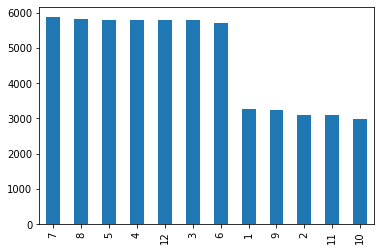

In [24]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split

from google.colab import files
uploaded = files.upload()

data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
data.head()

le =LabelEncoder()

Holiday_labels = le.fit_transform(data['holiday'])
{index: label for index , label in enumerate(le.classes_)}

weather_main = le.fit_transform(data['weather_main'])
{index: label for index , label in enumerate(le.classes_)}

weather_description = le.fit_transform(data['weather_description'])
{index: label for index , label in enumerate(le.classes_)}

data['holiday'] = le.fit_transform(data['holiday'])
data['weather_main'] = le.fit_transform(data['weather_main'])
data['weather_description'] = le.fit_transform(data['weather_description'])

#Aggregate rows with same date-time
data_agg = data.groupby('date_time',as_index=False).agg('max')

#Convert date_time column to datetime format
data_agg['date_time'] = pd.to_datetime(data_agg['date_time'])

#Create column with hours from date_time
data_agg['hour'] = data_agg['date_time'].dt.hour
data_agg['hour'].value_counts().plot(kind='bar')

#Create column with day of the week from date_time
data_agg['day_of_week'] = data_agg['date_time'].dt.dayofweek
data_agg['day_of_week'].value_counts().plot(kind='bar')

#Create column with month from date_time
data_agg['month'] = data_agg['date_time'].dt.month
data_agg['month'].value_counts().plot(kind='bar')

data_agg.head()
data_agg.drop(['date_time'], axis=1)

#Dave preprocessed data to csv
data_agg.to_csv("Metro-Interstate-Traffic-Volume-Encoded.csv", index=False)

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# We have imported all dependencied
df = pd.read_csv('Metro-Interstate-Traffic-Volume-Encoded.csv')
df = df.drop(['date_time'],axis=1) # Drop Date feature

print(df.info()) # Overview of dataset
df = df.dropna(inplace=False)  # Remove all nan entries.

df_train = df[:32460]    # 60% training data and 40% testing data
df_test = df[32460:]

# For normalizing dataset
def normalization(raw_data):
    for col_num in range(raw_data.shape[1]):
        if raw_data.iloc[:,col_num].dtype == np.float or raw_data.iloc[:,col_num].dtype == np.int:
            raw_data.iloc[:,col_num] = (raw_data.iloc[:,col_num] - raw_data.iloc[:,col_num].mean()) / (raw_data.iloc[:,col_num].max() - raw_data.iloc[:,col_num].min())
    return raw_data

dataset = normalization(df)
x_data = df.drop('traffic_volume',axis=1)
y_data = df['traffic_volume'][:,None]
X_train,X_test,Y_train,Y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=0)

Y_train = np.reshape(Y_train, (-1, 1))
y_test = np.reshape(Y_test, (-1, 1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)

print(scaler_x.fit(X_test))
xval_scale=scaler_x.transform(X_test)

print(scaler_y.fit(Y_train))
ytrain_scale=scaler_y.transform(Y_train)

print(scaler_y.fit(Y_test))
yval_scale=scaler_y.transform(Y_test)

# For denormalizing dataset
def denormalize(df,norm_data):
    df = df['traffic_volume'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    return new

#Network parameters
n_hidden1 = 10
n_hidden2 = 10
n_input = 10
n_output = 1

#Learning parameters
learning_constant = 0.001
number_epochs = 30

def neural_network(input_d, n_input):
    #layer 1 multiplying and adding bias then activation function
    w1 = tf.Variable(tf.random_uniform([n_input,10]))
    b1 = tf.Variable(tf.zeros([n_hidden1]))
    layer_1 = tf.add(tf.matmul(input_d,w1), b1)
    layer_1 = tf.nn.relu(layer_1)

    #layer 2 multiplying and adding bias then activation function
    w2 = tf.Variable(tf.random_uniform([10,10]))
    b2 = tf.Variable(tf.zeros([n_hidden2]))
    layer_2 = tf.add(tf.matmul(layer_1,w2), b2)
    layer_2 = tf.nn.relu(layer_2)

    #Output layer multiplying and adding bias then activation function (output layer has one node only)
    w3 = tf.Variable(tf.random_uniform([10,1]))
    b3 = tf.Variable(tf.zeros([n_output]))
    output = tf.add(tf.matmul(layer_2,w3), b3)
   
    return output

#Defining the input and the output
tf.disable_v2_behavior()
X = tf.placeholder("float")
Y = tf.placeholder("float")

output = neural_network(X, n_input)

#Mean squared error cost function
cost = tf.reduce_mean(tf.square(output-Y))
loss_op = tf.reduce_mean(tf.math.squared_difference(output,Y))

#Gradinent Descent optimiztion for updating weights and biases
optimizer = tf.train.GradientDescentOptimizer(learning_constant).minimize(loss_op)

c_t = []
c_test = []

with tf.Session() as sess:
    #Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for i in range(number_epochs):
        for j in range(X_train.shape[0]):
            sess.run(optimizer,feed_dict= {X:X_train.iloc[j,:].values.reshape(n_output,n_input), Y:Y_train[j]})
        c_t.append(sess.run(loss_op, feed_dict={X:X_train,Y:Y_train}))
        c_test.append(sess.run(loss_op, feed_dict={X:X_test,Y:Y_test}))
        print("------------------------------")
        print('Epoch :',i,'Cost :',c_t[i])

    #Predict output of test data after training
    pred = sess.run(output, feed_dict={X:X_test})
    print("==============================")
    print('Cost :',sess.run(loss_op, feed_dict={X:X_test,Y:Y_test}))

    #Accuracy 
    accuracy=tf.keras.losses.MSE(pred, Y_test)
    acc = accuracy.eval({X: X_train, Y:Y_train})
    print("Accuracy:", acc)
    op = output.eval({X: X_train})

    #Calculate the Root Mean Squared Error
    mse = mean_squared_error(Y_test, pred)
    rmse = sqrt(mse)
    print("Root Mean Squared Error:", rmse)

    #Denormalize output data     
    Y_test = denormalize(df_test,Y_test)
    pred = denormalize(df_test,pred)

    if input('Save model? [Y/N]') == 'Y':
      saver.save(sess,'Metro-Interstate-Traffic-Volume-Encoded_dataset.ckpt')
      print('Model Saved')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              40575 non-null  int64  
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  int64  
 6   weather_description  40575 non-null  int64  
 7   traffic_volume       40575 non-null  int64  
 8   hour                 40575 non-null  int64  
 9   day_of_week          40575 non-null  int64  
 10  month                40575 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 3.4 MB
None
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
--

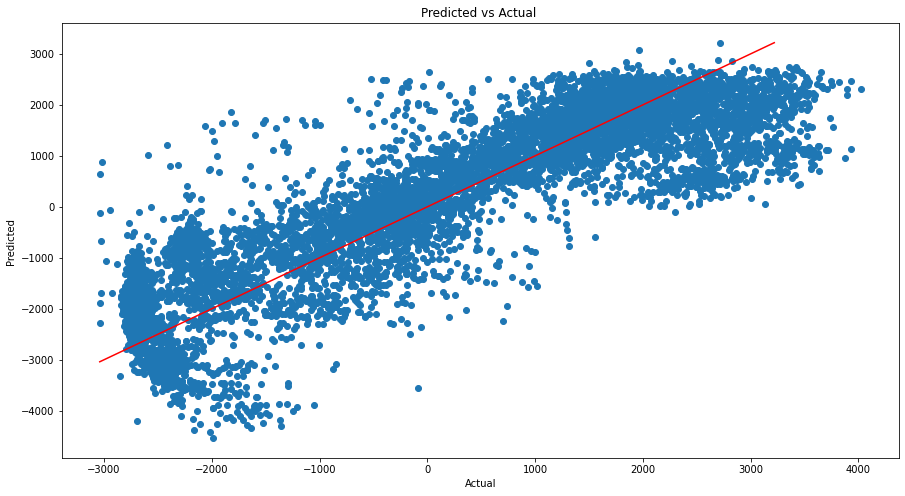

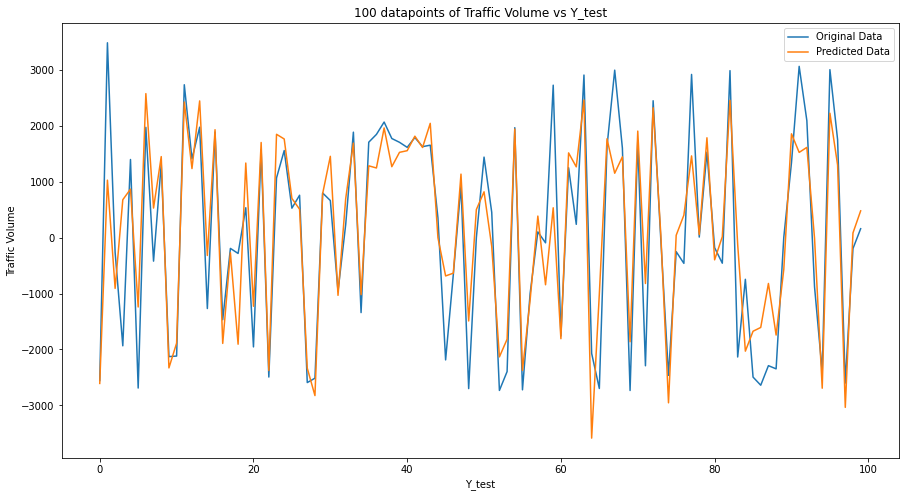

In [43]:
#Plotting the graph 
plt.figure(figsize=(15,8))
plt.scatter (Y_test, pred) 
range = [Y_test.min (), pred.max ()] 
plt.plot (range, range, 'red') 
plt.title('Predicted vs Actual ')
plt.xlabel ('Actual') 
plt.ylabel ('Predicted ') 
plt.show ()

plt.figure(figsize=(15,8))
plt.plot(Y_test[:100],label="Original Data")
plt.plot(pred[:100],label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('Traffic Volume')
plt.xlabel('Y_test')
plt.title('100 datapoints of Traffic Volume vs Y_test')
plt.show()
